In [2]:
#! usr/bin/env python3
"""
assess cluster-wise stability of hierarchical clustering results
using boot striping and Jaccard index
Using linear assignment problem algorithm, a variation of stable marriage problem
"""
from typing import Union

import numpy as np
from scipy.optimize import linear_sum_assignment
import pandas as pd

from SupertypeTools import hierarchical_cluster

def jaccard(member_index1:list, member_index2:list) -> float:
    # calculate jaccard index between two groups
    s1 = set(member_index1)
    s2 = set(member_index2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

def max_jaccard(clustering1:np.array, clustering2:np.array):
    """
    since cluster name might change, max jaccard is used to indicate matching cluster between
    reference clustering (full sample) and bootstrap clustering
    """
    groups1 = np.unique(clustering1) # name of groups
    groups2 = np.unique(clustering2)
    jar_matrix = np.zeros((len(groups1),len(groups2))) # jaccard index matrix, storing jaccard index of all-to-all groups

    for i in range(len(groups1)):
        for j in range(len(groups2)):
            members1 = np.where(clustering1 == i)[0] # index of group members
            members2 = np.where(clustering2 == j)[0]
            jar_matrix[i,j] = jaccard(members1, members2)

    row_idx, col_idx = linear_sum_assignment(jar_matrix, maximize=True) # find the solution with maximum sum
    # print(jar_matrix, row_ind, col_ind)
    # print(groups1[row_ind])
    return row_idx, jar_matrix[row_idx, col_idx]

def bootstrap_sampling(sample_size:int, nb):
    """
    return index of samples
    """
    samples_idx = []
    idx = [i for i in range(sample_size)]
    for _ in range(nb):
        x = np.random.choice(idx, sample_size, replace=True).tolist()
        samples_idx.append(x)

    return samples_idx

def cluster_stability(dist_mat:pd.DataFrame, ref_clustering:pd.Series, NB:int=100, N_cluster:int=None,
 threshold:float=None, average:bool=True)->np.array:
    """
    returns average/step-wise jaccard index (similarity) of each cluster
    """
    # distance matrix is upper-triangle, change to square form
    dist_mat = dist_mat.add(dist_mat.T, fill_value=0)
    dist_mat = dist_mat.to_numpy()

    ref_groups = np.unique(ref_clustering)
    N_groups = len(ref_groups)
    N_samples = dist_mat.shape[0]

    jac_matrix = np.empty((NB, N_groups))
    jac_matrix[:] = np.nan
    bt_index = bootstrap_sampling(N_samples, NB)
    for i in range(NB):
        index = bt_index[i]
        dist_mat_bt = dist_mat[:,index][index,:]
        dist_mat_bt = pd.DataFrame(dist_mat_bt)
        ref_group = ref_clustering[index]

        bt_group, _ = hierarchical_cluster(dist_mat_bt, square=True, N=N_cluster, threshold=threshold)

        group_idx, group_jac = max_jaccard(ref_group, bt_group)

        jac_matrix[i, group_idx] = group_jac

    if average:
        return np.nanmean(jac_matrix, axis=0)

    else:
        return jac_matrix

# def nearest_centroid(Mat:pd.DataFrame, centroids:pd.Series, threshold:float=None, square:bool=False):
#     if not square:
#         Mat = Mat.add(Mat.T, fill_value=0)

#     # extract rows that contains distance to centroids
#     dist_to_centroid = Mat[cluster_centroids.index.to_numpy()]
#     centroid_dict = centroids.to_dict()
#     # centroid_dict = {value:key for key, value in centroid_dict.items()}
#     dist_to_centroid = dist_to_centroid.rename(columns = centroid_dict)
#     # dist_to_centroid
#     clusters = dist_to_centroid.idxmin(axis=1)
#     return clusters
def nearest_anchors(Mat:pd.DataFrame, anchors:Union[dict, pd.Series], threshold:float=None, square:bool=False):
    # anchors is dict {anchor allele:cluster}
    if not square:
        Mat = Mat.add(Mat.T, fill_value=0)

    if type(anchors) == pd.Series:
        anchors = anchors.to_dict()
    
    dist_to_anchors = Mat[anchors.keys()]

    dist_to_anchors = dist_to_anchors.groupby(by=anchors, axis=1).mean()
    # print(dist_to_anchors.to_string())
    clusters = dist_to_anchors.idxmin(axis=1)
    return clusters

def nn_stability(dist_mat:pd.DataFrame, ref_clustering:pd.Series, anchors:Union[dict, pd.Series], NB:int=100,
threshold:float=None, average:bool=True)->np.array:

    dist_mat = dist_mat.add(dist_mat.T, fill_value=0)
    # dist_mat = dist_mat.to_numpy()

    ref_groups = np.unique(ref_clustering)

    if type(anchors) == pd.Series:
        anchor_groups = np.unique(anchors)
        anchors = anchors.to_dict()

    else:
        anchor_groups = np.unique(list(anchors.values()))

    if not np.all(ref_groups == anchor_groups):
        raise ValueError("anchors doesn't match referece clusters")
    
    N_groups = len(ref_groups)
    N_samples = dist_mat.shape[0]

    jac_matrix = np.empty((NB, N_groups))
    jac_matrix[:] = np.nan
    bt_index = bootstrap_sampling(N_samples, NB)
    for i in range(NB):
        index = bt_index[i]
        dist_to_anchors = dist_mat[anchors.keys()].iloc[index]
        # dist_to_anchors = pd.DataFrame(dist_to_anchors)
        ref_group = ref_clustering[index]

        # bt_group, _ = hierarchical_cluster(dist_mat_bt, square=True, N=N_cluster, threshold=threshold)
        bt_group = nearest_anchors(dist_to_anchors, anchors,square=True)

        group_idx, group_jac = max_jaccard(ref_group, bt_group)

        jac_matrix[i, group_idx] = group_jac

    if average:
        return np.nanmean(jac_matrix, axis=0)

    else:
        return jac_matrix



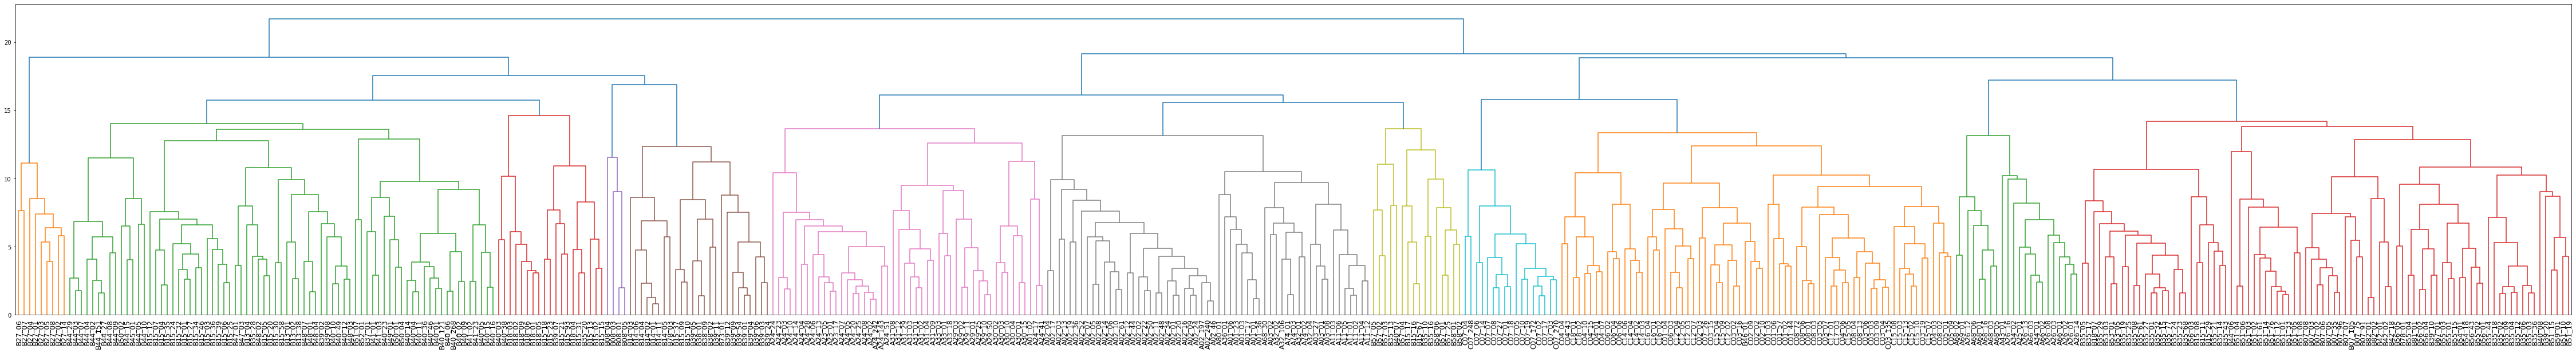

In [3]:
Mat = pd.read_csv("HLA-I_cg_dist.csv", index_col=0)
cluster, order, cluster_centroids = hierarchical_cluster(Mat, N=12, L='complete', color_threshold=None, plot_dendro=True, centroid=True)
# L choose from ['complete', 'average', 'single']
# print(cluster_stability(Mat, cluster, 100, N_cluster=12, average=True))

In [32]:
pd.Series(cluster_stability(Mat, cluster, 100, N_cluster=12, average=True))

0     0.494629
1     0.775186
2     0.892289
3     0.622712
4     0.829973
5     0.576957
6     0.623315
7     0.980055
8     0.818524
9     0.814496
10    0.348661
11    0.871022
dtype: float64

In [4]:
# anchor_dict = {'A01_01':5,'A30_03':3,'A30_01':3,'A02_01':5,'A02_03':5,'A02_06':5,'A02_07':5,'A03_01':5,'A11_01':5,'A68_01':6,'A23_01':3,
# 'A24_02':3,'B07_02':1,'B35_01':1,'B42_01':1,'B51_01':1,'B08_01':8,'B14_02':11,'B27_03':7,'B27_04':7,'B27_05':7,'B27_06':7,
# 'B39_01':11,'B18_01':0,'B37_01':4,'B40_01':4,'B40_02':4,'B44_02':4,'B44_03':4,'B57_01':10,'B58_01':10,'B15_01':4,'B46_01':2,
# 'C01_02':2,'C03_04':2,'C08_02':2,'C16_04':2,'C04_01':2,'C05_01':2,'C06_02':2,'C15_10':2,'C07_01':9,'C08_01':2}

# anchor_dict = {'A01_01':5,'A02_01':5,'A02_07':5,'A03_01':5,'A11_01':5,
# 'A30_03':3,'A23_01':3,'A24_02':3,'A29_02':3,
# 'A68_01':6,
# 'B07_02':1,'B35_01':1,'B42_01':1,'B51_01':1,
# 'B08_01':8,
# 'B14_02':11,'B39_01':11,
# 'B27_03':7,'B27_04':7,'B27_05':7,'B27_06':7,
# 'B18_01':0,
# 'B37_01':4,'B40_01':4,'B40_02':4,'B44_02':4,'B44_03':4,'B15_01':4,
# 'B57_01':10,'B58_01':10,
# 'B46_01':2,'C01_02':2,'C03_04':2,'C08_02':2,'C16_04':2,'C04_01':2,'C05_01':2,'C06_02':2,'C15_10':2,'C08_01':2,
# 'C07_01':9}

anchor_intercect_dict = {'A01_01':5,'A02_01':5,'A02_03':5,'A02_06':5,'A02_07':5,'A03_01':5,'A11_01':5,'A23_01':3,'A24_02':3,'A30_01':3,'A68_01':6,'B07_02':1,'B08_01':8,'B14_02':11,'B15_01':4,'B18_01':0,'B27_05':7,'B35_01':1,'B39_01':11,'B40_01':4,'B40_02':4,'B42_01':1,'B44_02':4,'B44_03':4,'B46_01':2,'B51_01':1,'B57_01':10,'B58_01':10,'C04_01':2,'C05_01':2,'C06_02':2,'C08_02':2,'C07_01':9}
anchor_crystal_dict = {'A01_01':5,'A02_01':5,'A02_03':5,'A02_06':5,'A02_07':5,'A03_01':5,'A11_01':5,'A23_01':3,'A24_02':3,'A30_01':3,'A30_03':3,'A68_01':6,'B07_02':1,'B08_01':8,'B14_02':11,'B15_01':4,'B18_01':0,'B27_03':7,'B27_04':7,'B27_05':7,'B27_06':7,'B35_01':1,'B37_01':4,'B39_01':11,'B40_01':4,'B40_02':4,'B42_01':1,'B44_02':4,'B44_03':4,'B46_01':2,'B51_01':1,'B57_01':10,'B58_01':10,'C01_02':2,'C03_04':2,'C04_01':2,'C05_01':2,'C06_02':2,'C07_01':9,'C08_01':2,'C08_02':2,'C15_10':2,'C16_04':2}

cluster_a = nearest_anchors(Mat, anchor_intercect_dict)
agreement = cluster == cluster_a
sum(agreement)/len(cluster)
# pd.Series(nn_stability(Mat, cluster, anchor_intercect_dict))

0.912751677852349

In [31]:
crystal_list = ['A01_01','A30_03','A30_01','A02_01','A02_03','A02_06','A02_07','A03_01','A11_01','A68_01','A23_01','A24_02','B07_02','B35_01','B42_01','B51_01','B08_01','B14_02','B27_03','B27_04','B27_05','B27_06','B27_09','B39_01','B18_01','B37_01','B40_01','B40_02','B44_02','B44_03','B57_01','B58_01','B15_01','B46_01','C01_02','C03_04','C08_02','C16_04','C04_01','C05_01','C06_02','C15_10','C05_17','C07_56','C08_01']
netMHC_list = ['A01_01','A02_01','A02_02','A02_03','A02_05','A02_06','A02_07','A02_11','A02_12','A02_16','A02_17','A02_19','A02_50','A03_01','A11_01','A23_01','A24_02','A24_03','A25_01','A26_01','A26_02','A26_03','A29_02','A30_01','A30_02','A31_01','A32_01','A33_01','A66_01','A68_01','A68_02','A69_01','A80_01','B07_02','B08_01','B08_03','B14_02','B15_01','B15_02','B15_03','B15_09','B15_17','B18_01','B27_05','B35_01','B35_03','B38_01','B39_01','B40_01','B40_02','B42_01','B44_02','B44_03','B45_01','B46_01','B48_01','B51_01','B53_01','B54_01','B57_01','B58_01','B58_02','B73_01','C03_03','C04_01','C05_01','C06_02','C07_01','C07_02','C08_02','C12_03','C14_02','C15_02']
crystal = set(crystal_list)
netMHC = set(netMHC_list)
# crystal.intersection(netMHC)

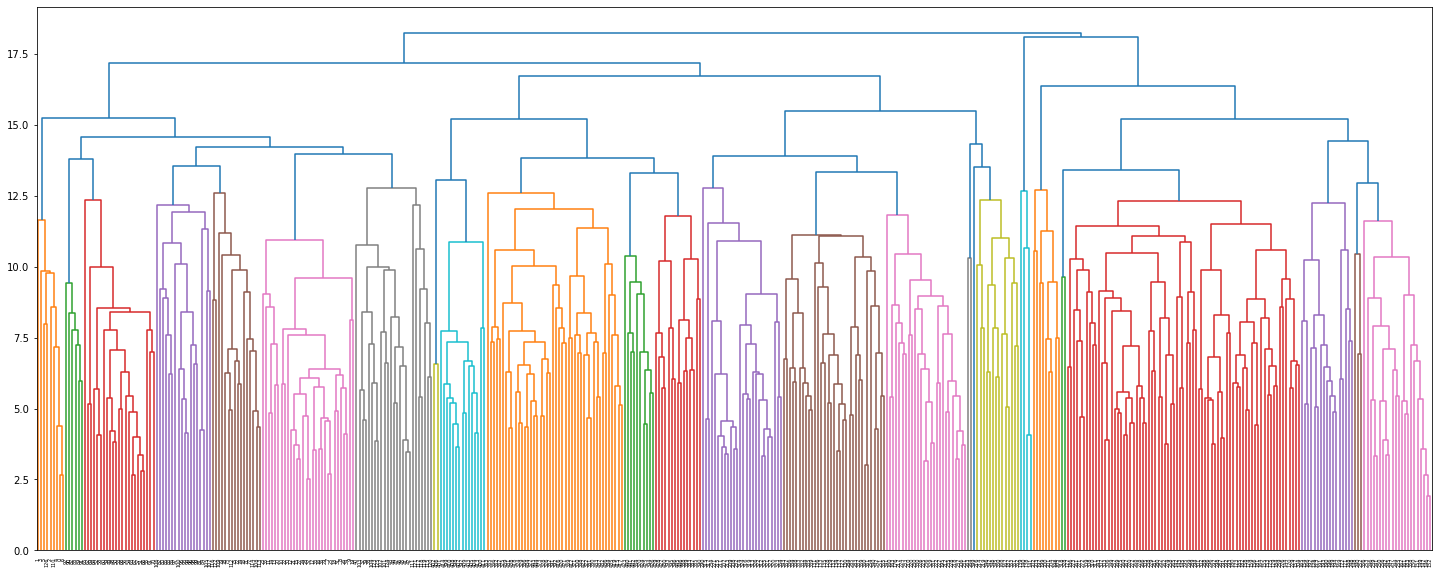

In [29]:
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree, fcluster
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
Mat = pd.read_csv("HLA-I_cg_dist.csv", index_col=0)
Mat = Mat.add(Mat.T, fill_value=0)
Mat_condense = squareform(Mat)
Z = linkage(Mat_condense, 'weighted')
#single complete average weighted centroid median 

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()


In [32]:
# cuttree = cut_tree(Z, n_clusters=None, height=8)
fcluster(Z, t=16, criterion='maxclust')
# inconsistent distance monocrit
# maxclust maxclust_monocrit

array([ 1,  1,  1,  1,  1,  1,  1,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  5,
        5,  5,  5,  3,  3,  3,  3,  3,  1,  5,  3,  3,  3,  5,  3,  5,  5,
        5,  5,  5,  3,  5,  5,  5,  1,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9, 12, 12, 12, 12, 14, 14, 14, 14, 16, 16, 16, 16, 16, 16, 16,
       14, 15, 14, 14, 14, 14, 14,  9, 16, 16,  9, 14, 15, 15, 11, 11, 15,
       14, 15, 15, 14, 14, 14,  9, 14, 15, 14, 14, 14, 14, 16, 14, 14, 14,
       11, 15, 15, 15, 15, 15, 15, 15,  9, 15, 13, 13, 13, 13, 13, 13, 13,
       13, 13,  9,  8,  8,  8,  9,  8,  9,  8, 11,  8, 11,  9,  9, 11,  9,
        8,  9, 15,  9,  9